# Demand Forecasting Analysis

## Introduction
**Objective**: Analyse past 2 years of e-commerce operations data, in order to build and optimize a forecasting model for the next 4, 6 and 8 weeks, specific to:
-  Daily Order Volume
- Daily customer care tickets

## Initiation

### Import Libraries

In [7]:
# Basic imports for data analysis
from pathlib import Path
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

# Set pandas display options for full visibility
pd.set_option('display.max_columns', None)

# Imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns 



### Import Dataset

In [ ]:
# Import dataset
repo_root = Path.cwd().parent
df = pd.read_csv(repo_root / "data" / "daily_demand.csv")

In [9]:
df.head()

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion
0,2023-01-01,613,1586,44791.35,78,1,1,0
1,2023-01-02,598,1026,50143.22,49,0,0,0
2,2023-01-03,522,1455,38737.17,61,0,0,0
3,2023-01-04,519,1287,25786.90,54,0,0,0
4,2023-01-05,609,1145,41630.79,54,0,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   730 non-null    object 
 1   orders                 730 non-null    int64  
 2   units_sold             730 non-null    int64  
 3   revenue                730 non-null    float64
 4   customer_care_tickets  730 non-null    int64  
 5   is_weekend             730 non-null    int64  
 6   is_holiday             730 non-null    int64  
 7   is_promotion           730 non-null    int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 45.8+ KB


We don't have any NaNs in our dataset.

In [ ]:
# Summary Statistics for table data
df.describe(include= 'all')

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion
count,730,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
unique,728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2024-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,926.845205,2119.484932,59922.678534,97.912329,0.286301,0.027397,0.078082
std,NaN,445.959697,1092.318130,30882.044720,56.829714,0.452342,0.163350,0.268485
min,NaN,119.000000,292.000000,8477.870000,10.000000,0.000000,0.000000,0.000000
25%,NaN,671.250000,1453.250000,41525.125000,65.000000,0.000000,0.000000,0.000000
50%,NaN,823.000000,1876.500000,53336.095000,84.000000,0.000000,0.000000,0.000000
75%,NaN,1075.750000,2479.500000,70341.242500,111.750000,1.000000,0.000000,0.000000


### Data Cleaning

#### Correction of date format

In [12]:
df['date'] = pd.to_datetime(df['date'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   730 non-null    datetime64[ns]
 1   orders                 730 non-null    int64         
 2   units_sold             730 non-null    int64         
 3   revenue                730 non-null    float64       
 4   customer_care_tickets  730 non-null    int64         
 5   is_weekend             730 non-null    int64         
 6   is_holiday             730 non-null    int64         
 7   is_promotion           730 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 45.8 KB


- Other data columns are in the correct format.
- Headers are named conveniently and don't require changes.

#### Check for duplicates

In [14]:
df.duplicated().sum()

0

- No duplicate values for entire rows observed.

## Outlier Detection and Analysis

### Outlier Identification

#### IQR Approach

In [15]:
# Running a loop to create variables for 75th and 25th Percentile, based on which we derive the Inter-Quartile Range (IQR). This would thereafter be 
# used to derive upper and lower limits as classification of outliers.
cols = ["orders", "units_sold", "revenue", "customer_care_tickets"]

for col in cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    globals()[f"perc25_{col}"] = q1
    globals()[f"perc75_{col}"] = q3
    globals()[f"iqr_{col}"] = iqr
    globals()[f"upper_limit_{col}"] = q3 + 1.5 * iqr
    globals()[f"lower_limit_{col}"] = q1 - 1.5 * iqr

#### z-score Approach

In [16]:
# Generating z-scores for numerical columns
df_z = df.copy()
for c in cols:
    df_z[f"zscore_{c}"] = stats.zscore(df_z[c])

### Outlier Visualization

#### IQR Outlier visualization

In [21]:
# Create flag for outliers
df_iqr = df.copy()
df_iqr['is_outlier'] = df_iqr['orders'].apply(
    lambda x: 1 if x > upper_limit_orders or x < lower_limit_orders else 0
)
df_iqr[df_iqr['is_outlier'] == 1].head()

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion,is_outlier
9,2023-01-10,1877,2929,156115.11,222,0,0,0,1
72,2023-03-14,1815,5112,139880.71,187,0,0,0,1
127,2023-05-07,2431,6294,188250.21,282,0,0,0,1
135,2023-05-15,3415,6885,227051.86,400,0,0,0,1
185,2023-07-04,1720,2621,98694.02,286,0,1,0,1


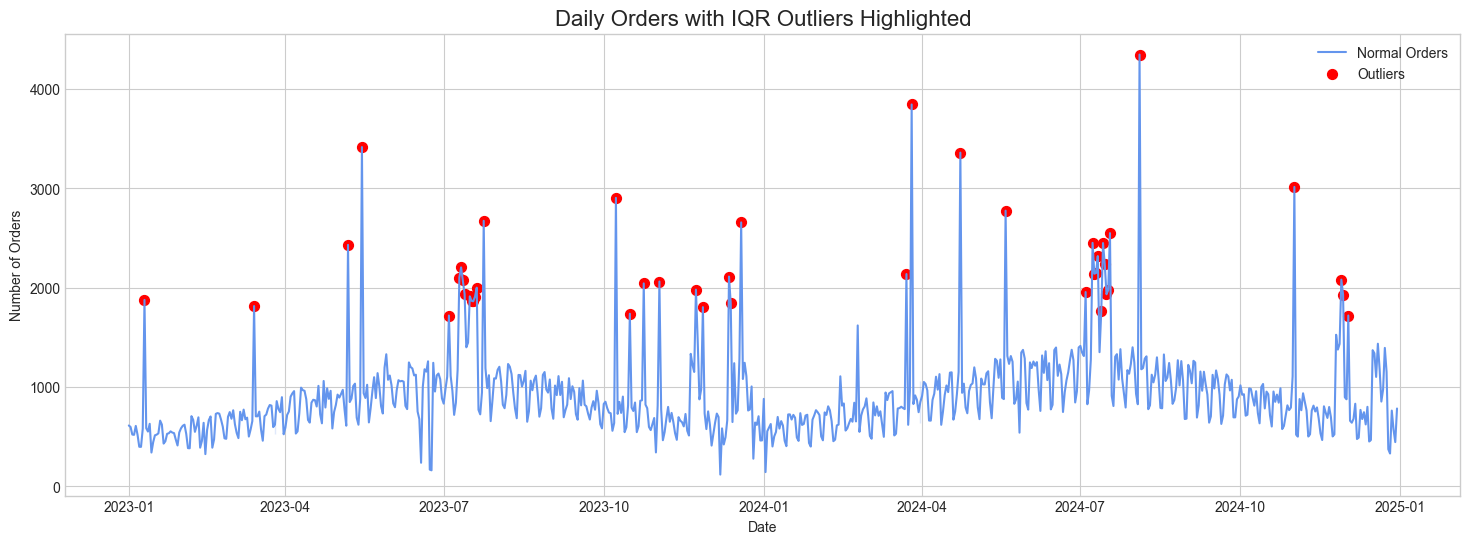

In [25]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 6))

# Plot the main time series line
sns.lineplot(x='date', y='orders', data=df_iqr, ax=ax, label='Normal Orders', color='cornflowerblue')

# Overlay the outliers as distinct points
outliers_df = df_iqr[df_iqr['is_outlier'] == 1]
ax.scatter(outliers_df['date'], outliers_df['orders'], color='red', s=50, label='Outliers')

ax.set_title('Daily Orders with IQR Outliers Highlighted', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Orders')
ax.legend()
plt.show()

### Observation Summary (Handling of Outliers)

## Feature Engineering

### Create Relevant Feature

### Correlation Analysis

## Data Preparation 

### Data Transformation

### Set up Training & Testing Data

## Model Build 

### Model 1

### Model 2

## Model Evaluation